# About this notebook

## Version 1
- PyTorch tf_efficientnetv2_b0 starter code
- Triple Stratify
- 5 folds
- 30 epochs
- batch size 64 no accumulation
- Custom learning scheduler
- With data augmentation
- meta_features

# Improvements maybe
- Use ArcFace or add triplet loss with cross entropy for accuracy improvement
- Use meta featues 'Age' 'variety' to improove the performance of the models
- Use focal Loss (already implemented)

# acknowledgement
- Y.NAKAMA great [notebook](https://www.kaggle.com/yasufuminakama/herbarium-2020-pytorch-resnet18-train/notebook)

If this notebook is helpful, feel free to upvote :)

In [ ]:
!pip install timm
!pip install albumentations

In [ ]:
!pip install -q --upgrade wandb

In [1]:
import os
import gc
import numpy as np
import pandas as pd
from PIL import Image
import cv2 as cv
from matplotlib import pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 300

# Quick EDA

## Triple Stratified Leak-Free KFold CV by the legendary Chris @cdeotte

##### I've used the jpeg-melanoma-256x256 dataset made by chris deotte
##### In simple words, he created TFRecords which contain both the image data and tabular data (meta data) so you can easily build models that utilize both.

#### Stratify 1 - Isolate Patients :
- A single patient can have multiple images. Now all images from one patient are fully contained inside a single TFRecord. This prevents leakage during cross validation

#### Stratify 2 - Balance Malignant Images :
- The entire dataset has 1.8% malignant images. Each TFRecord contains 1.8% malignant images. This makes validation score more reliable.

#### Stratify 3 - Balance Patient Count Distribution :
- Some patients have as many as 115 images and some patients have as few as 2 images. When isolating patients into TFRecords, each record has an equal number of patients with 115 images, with 100, with 70, with 50, with 20, with 10, with 5, with 2, etc. This makes validation more reliable.

In [56]:
from src import preprocess
preprocess.meta_features

['sex', 'age_approx']

In [48]:
train_df = pd.read_csv('JPEG Melanoma 256x256\\train.csv')
test_df = pd.read_csv('JPEG Melanoma 256x256\\test.csv')
submission = pd.read_csv('JPEG Melanoma 256x256\\sample_submission.csv')
use_meta = True

train_df_2019 = pd.read_csv('archive (11)\\train.csv')
train_dir_2019 = 'archive (11)\\train'

train_dir = 'JPEG Melanoma 256x256\\train'
test_dir = 'JPEG Melanoma 256x256\\test'

In [3]:
train_df['path_jpeg'] = train_df['image_name'].apply(lambda x: os.path.join(train_dir, f'{x}.jpg'))
test_df['path_jpeg'] = test_df['image_name'].apply(lambda x: os.path.join(test_dir, f'{x}.jpg'))
train_df_2019['path_jpeg'] = train_df_2019['image_name'].apply(lambda x: os.path.join(train_dir_2019, f'{x}.jpg'))

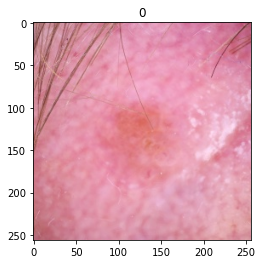

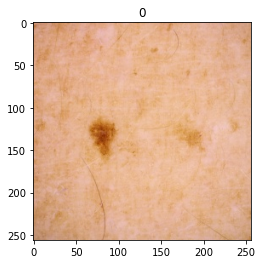

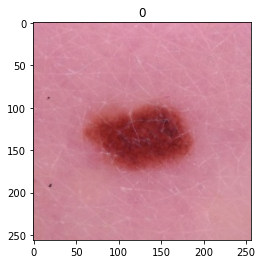

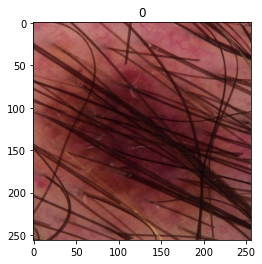

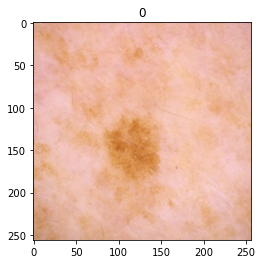

In [4]:
for i in range(5):
    image = cv.imread(train_df.loc[i, 'path_jpeg'])
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    label = train_df.loc[i, 'target']
    plt.imshow(image)
    plt.title(f"{label}")
    plt.show()

## CV schem

### Concatenate ISIC datatsets of 2019 and 2020

In [5]:
train_df_2019.diagnosis.value_counts()

NV      12875
MEL      4522
BCC      3323
BKL      2624
AK        867
SCC       628
VASC      253
DF        239
Name: diagnosis, dtype: int64

In [6]:
train_df.diagnosis.value_counts()

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
cafe-au-lait macule                       1
atypical melanocytic proliferation        1
Name: diagnosis, dtype: int64

In [7]:
# eliminate duplicated images 
train_df = train_df[train_df['tfrecord'] != -1].reset_index(drop=True)

tfrecord2fold = {
    2:0, 4:0, 5:0,
    1:1, 10:1, 13:1,
    0:2, 9:2, 12:2,
    3:3, 8:3, 11:3,
    6:4, 7:4, 14:4,
}

train_df['diagnosis'] = train_df['diagnosis'].apply(lambda x: x.replace('seborrheic keratosis', 'BKL'))
train_df['diagnosis'] = train_df['diagnosis'].apply(lambda x: x.replace('lichenoid keratosis', 'BKL'))
train_df['diagnosis'] = train_df['diagnosis'].apply(lambda x: x.replace('solar lentigo', 'BKL'))
train_df['diagnosis'] = train_df['diagnosis'].apply(lambda x: x.replace('lentigo NOS', 'BKL'))
train_df['diagnosis'] = train_df['diagnosis'].apply(lambda x: x.replace('cafe-au-lait macule', 'unknown'))
train_df['diagnosis'] = train_df['diagnosis'].apply(lambda x: x.replace('atypical melanocytic proliferation', 'unknown'))

train_df['fold'] = train_df['tfrecord'].map(tfrecord2fold)
train_df_2019['fold'] = train_df_2019['tfrecord'] % 5

train_df_2019['diagnosis'] = train_df_2019['diagnosis'].apply(lambda x: x.replace('NV', 'nevus'))
train_df_2019['diagnosis'] = train_df_2019['diagnosis'].apply(lambda x: x.replace('MEL', 'melanoma'))
df_train = pd.concat([train_df, train_df_2019]).reset_index(drop=True)

In [8]:
diagnosis2idx = {d: idx for idx, d in enumerate(sorted(df_train.diagnosis.unique()))}
df_train['target'] = df_train['diagnosis'].map(diagnosis2idx)
mel_idx = diagnosis2idx['melanoma']

In [9]:
diagnosis2idx

{'AK': 0,
 'BCC': 1,
 'BKL': 2,
 'DF': 3,
 'SCC': 4,
 'VASC': 5,
 'melanoma': 6,
 'nevus': 7,
 'unknown': 8}

#### one-hot encoding of anatom_site_general_challenge

In [10]:
if use_meta:    
    # one-hot encoding of anatom_site_general_challenge feature
    concat = pd.concat([train_df['anatom_site_general_challenge'], test_df['anatom_site_general_challenge']], ignore_index=True)

    dummies = pd.get_dummies(concat, dummy_na=True, dtype=np.uint8, prefix='site')
    train_df = pd.concat([train_df, dummies.iloc[:train_df.shape[0]]], axis=1)
    test_df = pd.concat([test_df, dummies.iloc[train_df.shape[0]:].reset_index(drop=True)], axis=1)
    # Sex features
    train_df['sex'] = train_df['sex'].map({'male': 1, 'female': 0})
    test_df['sex'] = test_df['sex'].map({'male': 1, 'female': 0})
    train_df['sex'] = train_df['sex'].fillna(-1)
    test_df['sex'] = test_df['sex'].fillna(-1)

    # Age features
    train_df['age_approx'] /= 90
    test_df['age_approx'] /= 90
    train_df['age_approx'] = train_df['age_approx'].fillna(0)
    test_df['age_approx'] = test_df['age_approx'].fillna(0)
    train_df['patient_id'] = train_df['patient_id'].fillna(0)

    meta_features = ['sex', 'age_approx'] + [col for col in train_df.columns if col.startswith('site_')]

In [11]:
meta_features

['sex',
 'age_approx',
 'site_head/neck',
 'site_lower extremity',
 'site_oral/genital',
 'site_palms/soles',
 'site_torso',
 'site_upper extremity',
 'site_nan']

# Directory settings

In [12]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Configuration

In [13]:
class CFG:
    apex=False
    debug=True
    print_freq=100
    size=256
    num_workers=2
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts','OneCycleLR']
    epochs=15
    # CosineAnnealingLR params
    cosanneal_params={
        'T_max':10,
        'eta_min':1e-4*0.5,
        'last_epoch':-1
    }
    #ReduceLROnPlateau params
    reduce_params={
        'mode':'min',
        'factor':0.2,
        'patience':5,
        'eps':1e-6,
        'verbose':True
    }
    # CosineAnnealingWarmRestarts params
    cosanneal_res_params={
        'T_0':10,
        'eta_min':1e-6,
        'T_mult':1,
        'last_epoch':-1
    }
    # OneCycleLR params
    onecycle_params={
        'pct_start':0.1,
        'div_factor':1e1,
        'max_lr':1e-3,
        'steps_per_epoch':3, 
        'epochs':3
    }
    #batch_size=64
    momentum=0.9
    lr=1e-4
    weight_decay=1e-4
    gradient_accumulation_steps=1
    max_grad_norm=1000
    nfolds=5
    trn_folds=[0, 1, 2, 3, 4]
    model_name='efficientnet_b0'     #'vit_base_patch32_224_in21k' 'tf_efficientnetv2_b0' 'resnext50_32x4d' 'resnet50d' 'efficientnet_b0'
    preds_col = ['AK', 'BCC','BKL', 'DF', 'SCC','VASC','melanoma' ,'nevus', 'unknown']
    #preds_col = ['prediction']
    train=True
    early_stop=True
    target_size=len(preds_col)
    scale=30.0
    margin=0.50
    easy_margin=False
    ls_eps=0.0
    fc_dim=512
    early_stopping_steps=5
    grad_cam=False
    seed=42

    batch_size = 16
    smoothing=0.05
    t1=0.3 # bi-tempered-loss https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/202017
    t2=1.0 # bi-tempered-loss https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/202017

In [14]:
# ====================================================
# Library
# ====================================================
import sys
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
from torch.cuda import amp

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image
from PIL import ImageFile
# sometimes, you will have images without an ending bit
# this takes care of those kind of (corrupt) images
ImageFile.LOAD_TRUNCATED_IMAGES = True
import albumentations as A 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.optim.optimizer import Optimizer
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import albumentations as A
from torchvision import transforms ,datasets
from torchvision.utils import make_grid
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise,
                            Rotate, RandomResizedCrop, Cutout, ShiftScaleRotate)


import timm

from torch.cuda.amp import autocast, GradScaler

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
VERSION = 1

# W&B

In [15]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_key")

import wandb
wandb.login(key=wandb_api)

def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

run = wandb.init(project="Melanoma Competition Efficientnetb0 ", 
                 name=f"{CFG.model_name} batch size",
                 config=class2dict(CFG),
                 group=CFG.model_name,
                 job_type="train")

ModuleNotFoundError: No module named 'kaggle_secrets'

# Utils

In [16]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = log_loss(y_true, y_pred)
    return score

def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

# CV schem

In [17]:
#%%time
#skf = MultilabelStratifiedKFold(n_splits=CFG.nfolds, shuffle=True, random_state=CFG.seed)
#for fold, (trn_idx, vld_idx) in enumerate(skf.split(train_df, train_df[['label', 'age', 'variety']])):
#    train_df.loc[vld_idx, "fold"] = int(fold)
#train_df["fold"] = train_df["fold"].astype(int)

# Dataset

In [18]:
class SIIMISICDataset(Dataset):
    def __init__(self, csv, mode, transform=None):

        self.csv = csv.reset_index(drop=True)
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):
        row = self.csv.iloc[index]
        
        image = cv2.imread(row.path_jpeg)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if self.transform is not None:
            res = self.transform(image=image)
            image = res['image']
        else:
            image = image.astype(np.float32)

        if self.mode == 'test':
            return torch.tensor(image).float()
        else:
            return (torch.tensor(image).float(), torch.tensor(self.csv.iloc[index].target).long())

# Transforms

In [19]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose(
        [
           A.Resize(CFG.size, CFG.size),
           A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            A.Flip(p=0.5),
            
            #A.Cutout(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=180, p=0.5),
            A.ShiftScaleRotate(
                shift_limit = 0.1, scale_limit=0.1, rotate_limit=45, p=0.5
            ),
           
            ToTensorV2(p=1.0),
        ]
    )


    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


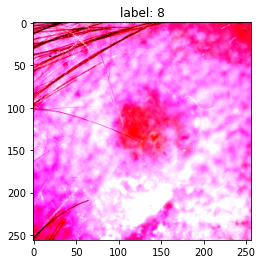

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


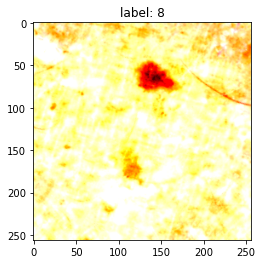

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


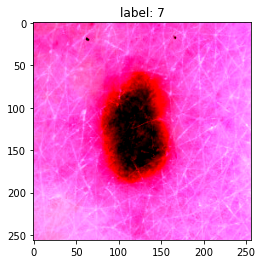

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


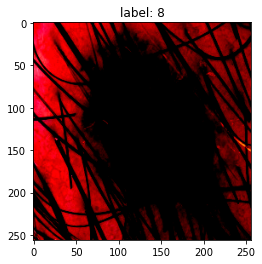

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


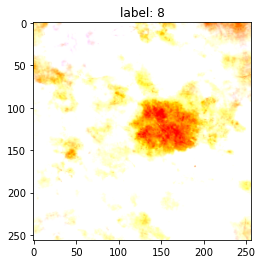

In [20]:
train_folds = df_train[df_train['fold'] != 0]
train_dataset = SIIMISICDataset(csv=train_folds,
                                mode='train',
                                transform=get_transforms(data='train'))
for i in range(5):
    plt.figure(figsize=(4, 4))
    image1 ,label = train_dataset[i]
    plt.imshow(image1.permute(2,1,0))
    plt.title(f'label: {label}')
    plt.show() 

# Model

In [21]:
sigmoid = torch.nn.Sigmoid()

class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * sigmoid(i)
        ctx.save_for_backward(i)
        return result
    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))
swish = Swish.apply

class Swish_module(nn.Module):
    def forward(self, x):
        return swish(x)
swish_layer = Swish_module()


class EfficientNetwork(nn.Module):
    def __init__(self,CFG, pretrained=True):
        super(EfficientNetwork, self).__init__()
        self.base_model = timm.create_model(CFG.model_name, pretrained=pretrained)
        #self.dropout = nn.Dropout(0.5)
        
        self.csv = nn.Sequential(nn.Linear(9, 250),
                                 nn.BatchNorm1d(250),
                                 Swish_module(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 128),
                                 nn.BatchNorm1d(128),
                                 Swish_module(),
                                 nn.Dropout(p=0.2))
        
        self.classification = nn.Linear(in_features=1000 + 128, out_features=9, bias=True)
        
    def forward(self, image, csv_data):
        out_image = self.base_model(image)
        out_csv = self.csv(csv_data)
        image_csv_data = torch.cat((out_image, out_csv), dim=1)
        out = self.classification(image_csv_data)

        return out


In [22]:
class CustomMolde(nn.Module):
    def __init__(self,CFG, pretrained=True):
        super(CustomMolde, self).__init__()
        self.base_model = timm.create_model(CFG.model_name, pretrained=pretrained)
        in_features = self.base_model.classifier.in_features
        self.base_model.classifier = nn.Linear(in_features, out_features=9, bias=True)
        
    def forward(self, image):
        out = self.base_model(image)
        return out

In [23]:
img_test,_ = train_dataset[0]

In [24]:
img_test = img_test.unsqueeze(0)

In [25]:
model = CustomMolde(CFG)
model(img_test)

tensor([[-0.0235, -0.0621,  0.1269,  0.1308, -0.0197,  0.0547, -0.0733, -0.1313,
          0.1307]], grad_fn=<AddmmBackward0>)

In [26]:
#model =  EfficientNetwork(CFG)
#model.to(device);

In [27]:
#images = torch.rand([5, 3, 256, 256])
#csv_data = torch.rand([5, 9])
#images = images.to(device)
#csv_data = csv_data.to(device)

## EarlyStopping

In [28]:
class EarlyStoppingFn:
    def __init__(self, patience=7, mode="max", delta=0.0001, tpu=False):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.tpu = tpu
        self.delta = delta
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, preds, fold):
        
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, preds, fold)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print("EarlyStopping counter {} out of {}".format(self.counter, self.patience))
            if self.counter >= self.patience:
                self.early_stop = True

        else :
            self.best_score = score
            self.save_checkpoint(epoch_score, model, preds, fold)
            self.counter = 0
    
    def save_checkpoint(self, epoch_score, model, preds, fold):
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            preds = preds[:, mel_idx]
            #print("Validation score improved ({} --> {}). Saving model!".format(self.val_score, epoch_score))
            LOGGER.info(f' - Save Best AUC: {epoch_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'preds_loss': preds},
                        f'{CFG.model_name}_fold{fold}_best_AUC.pth')

        self.val_score = epoch_score

# Helper functions

In [29]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.apex:
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images ,labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        
        images = images.to(device)
        #meta_data = meta_data.to(device)
        labels = labels.to(device)
        
        batch_size = labels.size(0)
        if CFG.apex:
            with autocast():
                #y_preds = model(images, meta_data)
                y_preds = model(images)
                loss = criterion(y_preds, labels)
        else:
            #y_preds = model(images, meta_data)
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f} '
                  'LR: {lr:.6f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        #wandb.log({f"[fold{fold}] loss": losses.val,
        #           f"[fold{fold}] lr": scheduler.get_lr()[0]
        #          })

    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images ,labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        
        images = images.to(device)
        #meta_data = meta_data.to(device)
        labels = labels.to(device)
        
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            #y_preds = model(images, meta_data)
            y_preds = model(images)
        #preds.append(y_preds.softmax(1).to('cpu').numpy())
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        #print(f'preds  : {preds}')
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

# Train loop

In [34]:
# ====================================================
# Train loop
# ====================================================

def train_loop(folds, fold):
    scaler = amp.GradScaler()
    LOGGER.info(f"========== fold: {fold} training ==========")
    
    if CFG.debug:
        train_folds = folds[folds['fold'] != fold].sample(300)
        valid_folds = folds[folds['fold'] == fold].sample(300)
        
    else:
        train_folds = folds[folds['fold'] != fold]
        valid_folds = folds[folds['fold'] == fold]
        
        
    train_images_path = train_folds.path_jpeg.values
    train_targets = train_folds.target.values
        
    valid_images_path = valid_folds.path_jpeg.values
    valid_targets = valid_folds.target.values
        
    train_dataset = SIIMISICDataset(csv=train_folds,
                                mode = 'train',
                                transform=get_transforms(data='train'))
        
    valid_dataset = SIIMISICDataset(csv=valid_folds,
                                mode = 'train',
                                transform=get_transforms(data='valid'))
        
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=CFG.batch_size, shuffle=True)
        
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=CFG.batch_size, shuffle=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, **CFG.reduce_params)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, **CFG.cosanneal_params)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, **CFG.cosanneal_res_params)
        return scheduler
    
    # ====================================================
    # model & optimizer
    # ====================================================
        
    model = CustomMolde(CFG)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss()
    es = EarlyStoppingFn(patience=5, mode="max")

    best_loss = np.inf
    best_auc = 0.0
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        #prediction = np.vstack((preds)).ravel()
        auc = metrics.roc_auc_score((valid_targets==mel_idx), preds[:, mel_idx])

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - AUC: {auc:.4f}')
        #wandb.log({f"[fold{fold}] epoch": epoch+1, 
        #           f"[fold{fold}] avg_train_loss": avg_loss, 
        #           f"[fold{fold}] avg_val_loss": avg_val_loss,
        #           f"[fold{fold}] auc": auc})
        
        
        #es(auc, model, preds, fold)
       # if es.early_stop:
       #     print("Early stopping")
       #     break
        if auc > best_auc:
            best_auc = auc
            LOGGER.info(f'Epoch {epoch+1} - Save Best auc: {best_auc:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds_loss': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_AUC.pth')
    
    valid_folds[CFG.preds_col] = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_AUC.pth', 
                                      map_location=torch.device('cpu'))['preds_loss']

    return valid_folds

In [35]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train 
    """

    def get_result(result_df):
        preds_loss = result_df[CFG.preds_col].values
        labels = result_df["target"].values
        AUC_score_loss = metrics.roc_auc_score((labels==mel_idx) ,preds_loss[:, mel_idx])
        LOGGER.info(f'AUC with best loss weights: {AUC_score_loss:<.4f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.nfolds):
            if fold in CFG.trn_folds:
                _oof_df = train_loop(df_train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df[['image_name','AK', 'BCC','BKL', 'DF', 'SCC','VASC','melanoma' ,'nevus', 'unknown','target']].to_csv(OUTPUT_DIR+f'{CFG.model_name}_oof_rgb_df_version{VERSION}.csv', index=False)
        

In [45]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [37]:
if __name__ == "__main__":
    main()

========== fold: 0 training ==========


Epoch: [1][0/19] Elapsed 0m 8s (remain 2m 33s) Loss: 2.2006(2.2006) Grad: 4.0598 LR: 0.000100  
Epoch: [1][18/19] Elapsed 0m 14s (remain 0m 0s) Loss: 1.8218(2.0603) Grad: 4.3676 LR: 0.000100  
EVAL: [0/19] Elapsed 0m 0s (remain 0m 2s) Loss: 1.8017(1.8017) 


Epoch 1 - avg_train_loss: 2.0603  avg_val_loss: 1.8071  time: 17s
Epoch 1 - AUC: 0.7629
Epoch 1 - Save Best auc: 0.7629 Model


EVAL: [18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 1.7924(1.8071) 
Epoch: [2][0/19] Elapsed 0m 0s (remain 0m 4s) Loss: 1.7784(1.7784) Grad: 3.9733 LR: 0.000098  
Epoch: [2][18/19] Elapsed 0m 6s (remain 0m 0s) Loss: 1.4230(1.5921) Grad: 4.2039 LR: 0.000098  
EVAL: [0/19] Elapsed 0m 0s (remain 0m 2s) Loss: 1.3820(1.3820) 


Epoch 2 - avg_train_loss: 1.5921  avg_val_loss: 1.3237  time: 9s
Epoch 2 - AUC: 0.8369
Epoch 2 - Save Best auc: 0.8369 Model


EVAL: [18/19] Elapsed 0m 2s (remain 0m 0s) Loss: 1.2654(1.3237) 


KeyboardInterrupt: 